# Gallery for DR8 - Abell Clusters (incomplete)

The purpose of this notebook is to build a nice gallery of object images for DR8.  The theme is the Abell Clusters.

For future reference: The notebook must be run from https://jupyter.nersc.gov with the following (approximate) activation script:

```bash
#!/bin/bash                                                                                                           
version=$1                                                                                                            
connection_file=$2                                                                                                    

desiconda_version=20180512-1.2.5-img
module use /global/common/software/desi/$NERSC_HOST/desiconda/$desiconda_version/modulefiles
module load desiconda

export LEGACYPIPE_DIR=$HOME/repos/git/legacypipe                                                                       

export PATH=$LEGACYPIPE_DIR/bin:${PATH}                                                                               
export PYTHONPATH=$LEGACYPIPE_DIR/py:${PYTHONPATH}                                                                    

export DUST_DIR=/global/project/projectdirs/desi/software/${NERSC_HOST}/dust/v0_0

export UNWISE_COADDS_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4/fulldepth:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
export UNWISE_COADDS_TIMERESOLVED_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4

export GAIA_CAT_DIR=/global/project/projectdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom/
export GAIA_CAT_VER=2

export TYCHO2_KD_DIR=/global/project/projectdirs/cosmo/staging/tycho2

export PS1CAT_DIR=/global/project/projectdirs/cosmo/work/ps1/cats/chunks-qz-star-v3 # calibration only

exec python -m ipykernel -f $connection_file
```

### Imports and paths

In [1]:
import os, sys
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [215]:
import fitsio
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord, FK5
from astropy.table import Table, vstack, Column
from PIL import Image, ImageDraw, ImageFont

In [108]:
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from astrometry.libkd.spherematch import match_radec

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
%matplotlib inline

### Preliminaries

Define the data release and the various output directories.

In [6]:
PIXSCALE = 0.3
#PIXSCALE = 2.62

In [7]:
dr = 'dr8'
drdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8'
gallerydir = os.path.join( os.getenv('SCRATCH'), dr, 'gallery')
samplefile = os.path.join(gallerydir, 'sample-{}.fits'.format(dr))

In [8]:
jpgdir = os.path.join(gallerydir, 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [9]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

In [113]:
LSLGAfile = os.path.join(os.getenv('LARGEGALAXIES_DIR'), 'LSLGA-v2.0.fits')
LSLGA = Table(fitsio.read(LSLGAfile, lower=True))

### Build the sample.

Use the sample of clusters from Abell et al. 1989, ApJS, 70, 1.

In [300]:
def read_abell(original=False, abellzcat=False):
    # Read and parse the original ACO catalog.
    abelldir = os.path.join(os.getenv('HOME'), 'research', 'data', 'catalogs', 'abell_clusters')
    if original:
        cat = Table(fitsio.read(os.path.join(abelldir, 'abell_clusters.fits'),
                                columns=['aco', 'z', 'rich', '_RA_icrs', '_DE_icrs'], lower=True))
        cat.rename_column('_ra_icrs', 'ra')
        cat.rename_column('_de_icrs', 'dec')
        cat.add_column(Column(name='name', data=['Abell {}'.format(aco) for aco in cat['aco']]))
        cat.add_column(Column(name='diam', data=np.repeat(1.0, len(cat)))) # [arcmin]
        cat = cat[(~np.isnan(cat['z']))]        
    elif abellzcat:
        # Read the abellzcat catalog.
        # https://heasarc.gsfc.nasa.gov/W3Browse/galaxy-catalog/abellzcat.html
        cat = Table(fitsio.read(os.path.join(abelldir, 'abell-zcat.fits'), lower=True))
        # Precess the coordinates
        #c = FK5(ra=cat['ra']*u.deg, dec=cat['dec']*u.deg, equinox='B1950').transform_to(FK5(equinox='J2000'))
        #cat['ra'] = c.ra.value
        #cat['dec'] = c.dec.value

        cat.rename_column('abell_radius', 'diam') # =2 Mpc *diameter* (comoving) in arcmin
        cat['diam'] /= 2
        zcut = [zflag.strip() == '' for zflag in cat['redshift_flag']]
        bcgcut = np.zeros(len(cat), dtype=bool)
        distcut = np.zeros(len(cat), dtype=bool)
        for ii, (bmclass, distclass) in enumerate(zip(cat['bautz_morgan_class'], 
                                                      cat['abell_distance_class'])):
            try:
                if int(bmclass.strip()) <= 2:
                    bcgcut[ii] = True
            except:
                pass
            try:
                if int(distclass.strip()) < 4:
                    distcut[ii] = True
            except:
                pass
        magcut = cat['mag_10'] < 18
        deccut = cat['dec'] > -15 # -30
        #cat = cat[zcut * bcgcut * magcut * distcut]
        #cat = cat[zcut * bcgcut * magcut * deccut]
        cat = cat[zcut * deccut * bcgcut]
    else:
        cat = ascii.read(os.path.join(abelldir, 'abell-tabula.tsv'), format='basic', 
                         comment='#', delimiter='|', data_start=0, 
                         names=['abell', 'ra_hms', 'dec_hms', 'const', 'mag10', 'ngal', 
                                'diam', 'classification', 'notes'])
        cat.add_column(Column(name='ra', length=len(cat), dtype='f8'))
        cat.add_column(Column(name='dec', length=len(cat), dtype='f8'))
        for ii, cc in enumerate(cat):
            ra = np.array(cc['ra_hms'].split(':')).astype('f4')
            dec = np.array(cc['dec_hms'].split(':')).astype('f4')
            cat['ra'][ii] = 15. * (ra[0] + (ra[1] + ra[2]/60.)/60.)
            cat['dec'][ii] = dec[0] + (dec[1] + dec[2]/60.)/60.
    
    # Cross-match with the LSLGA to ensure a nice galaxy in the mosaic.
    m1, m2, d12 = match_radec(cat['ra'], cat['dec'], LSLGA['ra'], LSLGA['dec'],
                              4/60, nearest=True)
    #cat = cat[m1]
    
    cat.add_column(Column(name='run', length=len(cat), dtype='S14'))
    return cat

In [301]:
cat = read_abell(abellzcat=True)
print(len(cat))
cat[['370' in nn for nn in cat['name']]]

68


name,ra,dec,mag_10,redshift,redshift_flag,ref_redshift,lii,bii,abell_richness_class,abell_distance_class,bautz_morgan_class,bautz_morgan_flag,diam,log_redshift_ratio,class,run
bytes10,float64,float64,float64,float64,bytes13,bytes12,float64,float64,bytes20,bytes20,bytes18,bytes17,float64,float64,bytes34,bytes14


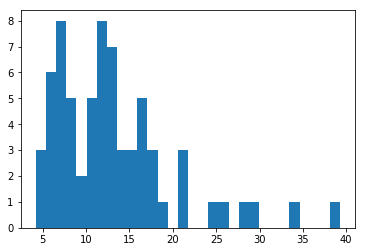

In [302]:
#_ = plt.hist(cat['mag_10'], bins=30)
_ = plt.hist(cat['diam'], bins=30)

### Restrict to objects that are in the DR8 footprint.

In [303]:
def read_all_ccds(dr='dr8'):                                                                                                        
    """Read the CCDs files, treating DECaLS and BASS+MzLS separately.                                                               
                                                                                                                                    
    """                                                                                                                             
    from astrometry.libkd.spherematch import tree_open                                                                              
    #survey = LegacySurveyData()                                                                                                    
                                                                                                                                    
    kdccds_north = []                                                                                                               
    for camera in ('90prime', 'mosaic'):                                                                                            
        ccdsfile = os.path.join(drdir, 'survey-ccds-{}-{}.kd.fits'.format(camera, dr))                                              
        ccds = tree_open(ccdsfile, 'ccds')                                                                                          
        print('Read {} CCDs from {}'.format(ccds.n, ccdsfile))                                                                      
        kdccds_north.append((ccdsfile, ccds))                                                                                       
                                                                                                                                    
    ccdsfile = os.path.join(drdir, 'survey-ccds-decam-{}.kd.fits'.format(dr))                                                       
    ccds = tree_open(ccdsfile, 'ccds')                                                                                              
    print('Read {} CCDs from {}'.format(ccds.n, ccdsfile))                                                                          
    kdccds_south = (ccdsfile, ccds)                                                                                                 
                                                                                                                                    
    return kdccds_north, kdccds_south                                                                                               

In [304]:
kdccds_north, kdccds_south = read_all_ccds()

Read 132066 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-90prime-dr8.kd.fits
Read 206834 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-mosaic-dr8.kd.fits
Read 3913907 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-decam-dr8.kd.fits


In [305]:
survey = LegacySurveyData()
survey.output_dir = gallerydir

In [306]:
def get_name(cat, nice=False):
    name = np.atleast_1d(cat['name'])
    if nice:
        outname = name
    else:
        outname = np.array([nn.replace(' ', '-').lower() for nn in name])
    if len(outname) == 1:
        outname = outname[0]
    return outname

In [307]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [308]:
def build_sample_one(cat, verbose=False):
    """Determine the "run", i.e., determine whether we should use the BASS+MzLS CCDs
    or the DECaLS CCDs file when running the pipeline. 

    """
    from astrometry.util.fits import fits_table, merge_tables   
    from astrometry.util.util import Tan                                    
    from astrometry.libkd.spherematch import tree_search_radec  
    from legacypipe.survey import ccds_touching_wcs                         

    ra, dec, diam = cat['ra'], cat['dec'], cat['diam']
    if dec < 25:                        
        run = 'decam'                       
    elif dec > 40:                                      
        run = '90prime-mosaic'      
    else:                               
        width = np.ceil(diam * 60 / PIXSCALE).astype(int)
        wcs = Tan(ra, dec, width/2+0.5, width/2+0.5,
                  -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                  float(width), float(width))  
                        
        # BASS+MzLS 
        TT = []         
        for fn, kd in kdccds_north:
            I = tree_search_radec(kd, ra, dec, 1.0)
            if len(I) == 0:
                continue
            TT.append(fits_table(fn, rows=I))  
        if len(TT) == 0:                    
            inorth = []                     
        else:                           
            ccds = merge_tables(TT, columns='fillzero')     
            inorth = ccds_touching_wcs(wcs, ccds)   
                                    
        # DECaLS            
        fn, kd = kdccds_south  
        I = tree_search_radec(kd, ra, dec, 1.0) 
        if len(I) > 0:          
            ccds = fits_table(fn, rows=I)  
            isouth = ccds_touching_wcs(wcs, ccds)  
        else: 
            isouth = []
        if len(inorth) > len(isouth): 
            run = '90prime-mosaic' 
        else:
            run = 'decam' 
            
        if verbose:
            print('Cluster {}: RA, Dec={:.6f}, {:.6f}: run={} ({} north CCDs, {} south CCDs).'.format(
                cat['name'], ra, dec, run, len(inorth), len(isouth)))
            
        if (len(inorth) == 0) * (len(isouth) == 0):
            run = None
            
    if run:
        cat['run'] = run
        return cat
    else:
        return None

In [309]:
def build_sample(cat, use_nproc=nproc, verbose=False):
    """Build the full sample with grz coverage in DR7."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, verbose) )

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    #result = list(zip(*result))
    # Remove non-matching objects and write out the sample
    outcat = vstack(list(filter(None, result)))
    print('Found {}/{} clusters in the DR8 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [310]:
#rr = build_sample(cat, use_nproc=4, verbose=True)

In [311]:
samplelogfile = os.path.join(gallerydir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the DR8 footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/dr8/gallery/build-sample.log
Found 66/68 objects in the DR8 footprint.
Total time = 7.568 seconds.


In [312]:
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

Writing /global/cscratch1/sd/ioannis/dr8/gallery/sample-dr8.fits


In [313]:
sample

name,ra,dec,mag_10,redshift,redshift_flag,ref_redshift,lii,bii,abell_richness_class,abell_distance_class,bautz_morgan_class,bautz_morgan_flag,diam,log_redshift_ratio,class,run
bytes10,float64,float64,float64,float64,bytes13,bytes12,float64,float64,bytes20,bytes20,bytes18,bytes17,float64,float64,bytes34,bytes14
ACO 2559,348.28,-13.69,17.0,0.0796,,A,58.36,-63.42,1,5,2,,12.1,-0.186,CLUSTER OF GALAXIES ABELL CLASS 1,decam
ACO 1317,173.78,-13.53,16.5,0.0695,,R,276.06,45.33,2,5,2,,13.65,-0.139,CLUSTER OF GALAXIES ABELL CLASS 2,decam
ACO 496,68.4,-13.25,15.3,0.032,,A,209.57,-36.48,1,3,1,,28.15,-0.234,CLUSTER OF GALAXIES ABELL CLASS 1,decam
ACO 2420,332.59,-12.19,16.8,0.0838,,A,46.48,-49.47,2,5,1,,11.55,-0.121,CLUSTER OF GALAXIES ABELL CLASS 2,decam
ACO 1837,210.44,-11.16,15.7,0.0376,,A,329.27,48.08,1,4,2,,24.15,-0.247,CLUSTER OF GALAXIES ABELL CLASS 1,decam
ACO 2670,358.54,-10.41,15.7,0.0745,,A,81.32,-68.52,3,4,2,,12.85,0.05,CLUSTER OF GALAXIES ABELL CLASS >2,decam
ACO 754,137.21,-9.64,15.2,0.056,,D,239.25,24.76,2,3,2,,16.65,0.03,CLUSTER OF GALAXIES ABELL CLASS 2,decam
ACO 85,10.41,-9.34,15.7,0.0518,,A,115.05,-72.06,1,4,1,,17.9,-0.108,CLUSTER OF GALAXIES ABELL CLASS 1,decam
ACO 2366,325.71,-6.87,15.9,0.0542,,A,48.4,-40.96,0,4,2,,17.15,-0.13,CLUSTER OF GALAXIES ABELL CLASS 0,decam


In [314]:
[print(ss['name'].replace(' ', '-'), ss['ra'], ss['dec']) for ss in sample]
#[print(ss['ra'], ss['dec']) for ss in sample]

ACO-2559 348.28 -13.69
ACO-1317 173.78 -13.53
ACO-496 68.4 -13.25
ACO-2420 332.59 -12.19
ACO-1837 210.44 -11.16
ACO-2670 358.54 -10.41
ACO-754 137.21 -9.64
ACO-85 10.41 -9.34
ACO-2366 325.71 -6.87
ACO-1651 194.85 -4.19
ACO-1650 194.69 -1.75
ACO-957 153.49 -0.92
ACO-279 29.09 1.06
ACO-2397 329.04 1.34
ACO-2457 338.94 1.48
ACO-180 20.47 3.01
ACO-1437 180.12 3.34
ACO-2029 227.74 5.76
ACO-2052 229.19 7.0
ACO-1890 214.39 8.19
ACO-882 147.81 8.25
ACO-2694 0.64 8.43
ACO-1541 186.86 8.84
ACO-1372 176.37 11.52
ACO-399 44.49 13.02
ACO-150 17.31 13.17
ACO-401 44.74 13.58
ACO-171 19.19 16.26
ACO-2589 351.0 16.82
ACO-1126 163.49 16.85
ACO-1991 223.63 18.63
ACO-1548 187.25 19.42
ACO-2626 354.13 21.16
ACO-2009 225.06 21.37
ACO-468 58.18 21.41
ACO-2107 234.95 21.77
ACO-1413 178.84 23.37
ACO-136 16.03 25.07
ACO-1927 217.76 25.66
ACO-1775 205.48 26.36
ACO-1795 207.25 26.59
ACO-2666 357.73 27.14
ACO-1504 183.83 27.52
ACO-1954 220.52 28.52
ACO-21 5.13 28.63
ACO-690 129.81 28.84
ACO-77 10.14 29.52
ACO-1487

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [196]:
def qa_sample():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='Abell Catalog')
    ax.scatter(sample['ra'], sample['dec'], s=20, marker='s', label='Objects in DR8 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='upper right')

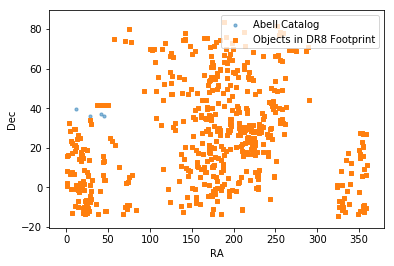

In [197]:
qa_sample()

### Generate the color mosaics for each object.

In [198]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [199]:
#name = get_name(sample)
#[print(ii, nn, d1, dd) for ii, (nn, d1, dd) in enumerate(zip(name, sample['diam'], sample['diam'] * 60 / 0.3))]
#print(sample['diam'].data * 60 / 1)

In [207]:
def custom_coadds_one(obj, scale=PIXSCALE, clobber=False, log=None):
    import subprocess
    #from legacypipe.runbrick import run_brick
    #from astrometry.util.multiproc import multiproc
    #from legacypipe.runbrick import stage_tims, run_brick
    #from legacypipe.coadds import make_coadds

    name = get_name(obj)
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        size = np.rint(obj['diam'] * 60 / scale).astype('int') # [pixels]
        if size > 500:
            size = 500
        #print('Generating mosaic for {} with width={} pixels.'.format(name, size))
        
        bands = ('g', 'r', 'z')
        rgb_kwargs = dict({'Q': 20, 'm': 0.03})
            
        brickname = custom_brickname(obj, prefix='custom-')
        
        cmd = 'python {legacypipe_dir}/py/legacypipe/runbrick.py '
        cmd += '--radec {ra} {dec} --width {width} --height {width} --pixscale {pixscale} '
        cmd += '--run {run} '
        cmd += '--threads {threads} --outdir {outdir} --no-write '
        cmd += '--apodize '
        cmd += '--stage image_coadds --skip-calibs '
    
        cmd = cmd.format(legacypipe_dir=os.getenv('LEGACYPIPE_DIR'), 
                         ra=obj['ra'], dec=obj['dec'], run=obj['run'].strip(),
                         width=size, pixscale=scale, threads=nproc, 
                         outdir=gallerydir)
    
        print(cmd, flush=True, file=log)
        err = subprocess.call(cmd.split(), stdout=log, stderr=log)
        if err != 0:
            print('Something we wrong; please check the logfile for {}.'.format(name))
            return 0
        else:
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            #    run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
            #              width=size, height=size, rgb_kwargs=rgb_kwargs, threads=nproc, 
            #              stages=['image_coadds'], splinesky=True, early_coadds=True, pixPsf=True, 
            #              hybridPsf=True, normalizePsf=True, write_pickles=False, depth_cut=False, 
            #              apodize=True, do_calibs=False, ceres=False)
            #sys.stdout.flush()    
            
            _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                                   'legacysurvey-{}-image.jpg'.format(brickname))
            if os.path.isfile(_jpgfile):
                shutil.copy(_jpgfile, jpgfile)
                shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))
            else:
                print('File {} not found; check log!'.format(_jpgfile))

In [208]:
#custom_coadds_one(sample[320], scale=2, clobber=True)

In [209]:
def custom_coadds(sample, clobber=False, log=None):
    for obj in sample:
        custom_coadds_one(obj, clobber=clobber, log=log)

In [210]:
coaddslogfile = os.path.join(gallerydir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    #with redirect_stdout(log):
    custom_coadds(sample, clobber=True, log=log)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

Generating the coadds.
Logging to /global/cscratch1/sd/ioannis/dr8/gallery/make-coadds.log
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-184900m13690/legacysurvey-custom-184900m13690-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-173780m13530/legacysurvey-custom-173780m13530-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-139630m12260/legacysurvey-custom-139630m12260-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-210420m11610/legacysurvey-custom-210420m11610-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-083080m11530/legacysurvey-custom-083080m11530-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-210440m11160/legacysurvey-custom-210440m11160-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-

In [ ]:
stop

### Add labels and a scale bar.

In [ ]:
barlen = np.round(60.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia.ttf')

In [ ]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [ ]:
def add_labels_one(obj, verbose=False):
    name = get_name(obj)
    nicename = get_name(obj, nice=True)
    
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    pngfile = os.path.join(pngdir, '{}.png'.format(name))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(name))
        
    im = Image.open(jpgfile)
    sz = im.size
    fntsize = np.round(sz[0]/28).astype('int')
    width = np.round(sz[0]/175).astype('int')
    font = ImageFont.truetype(fonttype, size=fntsize)
    draw = ImageDraw.Draw(im)
    # Label the object name--
    draw.text((0+fntsize*2, 0+fntsize*2), nicename, font=font)
    # Add a scale bar--
    x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
    draw.line((x0, yy, x1, yy), fill='white', width=width)
    im.save(pngfile)    
        
    # Generate a thumbnail
    if True:
        cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
        os.system(cmd)

In [ ]:
def add_labels(sample):
    labelargs = list()
    for obj in sample:
        labelargs.append((obj, False))

    #if False:
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [ ]:
%time add_labels(sample)

### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

    rsync -auvP /global/cscratch1/sd/ioannis/dr7/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr7/gallery/
    rsync -auvP /global/cscratch1/sd/ioannis/dr7/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr7/gallery/



In [ ]:
reject = ['arp_246', 'ic_0298', 'ugc_09532', 'ugca_173', 'ugca_174']
toss = np.zeros(len(sample), dtype=bool)
name = get_name(sample)
for ii, nn in enumerate(name):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in nn.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = sample[toss]
else:
    pngrej = []

In [ ]:
htmlfile = os.path.join(gallerydir, 'index.html')
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')
baseurl = 'http://legacysurvey.org/viewer'

In [ ]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            name = get_name(obj)
            nicename = get_name(obj, nice=True)
            pngfile = os.path.join('png', '{}.png'.format(name))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(name))
            img = 'src="{}" alt="{}"'.format(thumbfile, nicename)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for obj in pngrow:
            nicename = get_name(obj, nice=True)
            href = '{}/?layer=decals-{}&ra={:.8f}&dec={:.8f}&zoom=12'.format(baseurl, dr, obj['ra'], obj['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, nicename))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [ ]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>DR7 Image Gallery</h1>\n')
    
    #1966ApJS...14....1A
    
    html.write("""<p class="ls-gallery">This data release's gallery highlights the wide range
    of galaxies in Halton Arp's <i>Atlas of Peculiar Galaxies</i>.</p>\n <p>Each thumbnail links 
    to a larger image while the object name below each thumbnail links to the 
    <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  For reference, the horizontal white bar in 
    the lower-right corner of each image represents one arcminute.</p>\n""")
    html.write("""<p>For more eye candy, please visit the gallery of objects highlighted in the 
    <a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr6/gallery/">DR6 Gallery.</a></p>\n""")
    
    html_rows(pngkeep)
    html.write('<br />\n')

    html.write('</body></html>\n')

In [ ]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>DR6 Image Gallery - Rejected</h1>\n')
        html_rows(pngrej)
        html.write('</body></html>\n')